In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from datasets.ascad import AscadDataset
from models.recurrent import LstmModel
from datasets.transforms import ToTensor
from training.training import execute_epoch, train_batch, eval_batch
from training.metrics import get_loss

In [2]:
retrain = False
num_epochs = 10
batch_size = 256
grad_clip_norm = 1.0
metrics = {'loss': get_loss}
results_dir = os.path.join('.', 'results', 'lstm_autoencoder')

In [3]:
train_dataset = AscadDataset(train=True, transform=ToTensor())
test_dataset = AscadDataset(train=False, transform=ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
realistic_hindsight_values = [True, False]
delay_values = [0, 1, 2, 4, 8, 16]
train_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}
test_results = {(hs, d): {} for hs in realistic_hindsight_values for d in delay_values}

if retrain:
    for realistic_hindsight in realistic_hindsight_values:
        for delay in delay_values:
            model = LstmModel(delay=delay, realistic_hindsight=realistic_hindsight)
            loss_fn = nn.MSELoss()
            optimizer = optim.Adam(model.parameters())
            device = 'cuda'
            model = model.to(device)
            print('Realistic hindsight: {}, Delay: {}'.format(realistic_hindsight, delay))

            def train_epoch(update_params=True):
                if update_params:
                    results = execute_epoch(train_batch, train_dataloader, model, loss_fn, optimizer, device,
                                            batch_metric_fns=metrics, autoencoder=True, grad_clip_val=1.0)
                else:
                    results = execute_epoch(eval_batch, train_dataloader, model, loss_fn, device,
                                            batch_metric_fns=metrics, autoencoder=True)
                for key in results.keys():
                    if not(key in train_results[(realistic_hindsight, delay)].keys()):
                        train_results[(realistic_hindsight, delay)][key] = []
                    train_results[(realistic_hindsight, delay)][key].append(results[key])


            def test_epoch():
                results = execute_epoch(eval_batch, test_dataloader, model, loss_fn, device,
                                        batch_metric_fns=metrics, autoencoder=True)
                for key in results.keys():
                    if not(key in test_results[(realistic_hindsight, delay)].keys()):
                        test_results[(realistic_hindsight, delay)][key] = []
                    test_results[(realistic_hindsight, delay)][key].append(results[key])

            #train_epoch(update_params=False)
            test_epoch()
            for epoch in tqdm(range(num_epochs)):
                train_epoch()
                test_epoch()
            torch.save(model, os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))

Realistic hindsight: True, Delay: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:28<00:00, 98.85s/it]


Realistic hindsight: True, Delay: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:33<00:00, 99.32s/it]


Realistic hindsight: True, Delay: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:39<00:00, 99.97s/it]


Realistic hindsight: True, Delay: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:45<00:00, 100.52s/it]


Realistic hindsight: True, Delay: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:44<00:00, 100.48s/it]


Realistic hindsight: True, Delay: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:53<00:00, 101.31s/it]


Realistic hindsight: False, Delay: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:57<00:00, 95.71s/it]


Realistic hindsight: False, Delay: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:59<00:00, 95.92s/it]


Realistic hindsight: False, Delay: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:59<00:00, 95.99s/it]


Realistic hindsight: False, Delay: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:04<00:00, 96.49s/it]


Realistic hindsight: False, Delay: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:07<00:00, 96.70s/it]


Realistic hindsight: False, Delay: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:10<00:00, 97.00s/it]


In [ ]:
if retrain:
    with open(os.path.join(results_dir, 'train_results.pickle'), 'wb') as F:
        pickle.dump(train_results, F)
    with open(os.path.join(results_dir, 'test_results.pickle'), 'wb') as F:
        pickle.dump(test_results, F)

In [ ]:
with open(os.path.join(results_dir, 'train_results.pickle'), 'rb') as F:
    train_results = pickle.load(F)
with open(os.path.join(results_dir, 'test_results.pickle'), 'rb') as F:
    test_results = pickle.load(F)

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '4'),
 Text(4, 0, '8'),
 Text(5, 0, '16')]

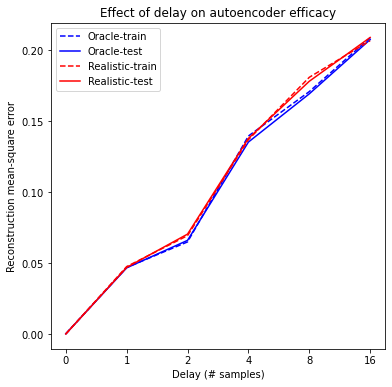

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([np.min(train_results[(False, d)]['loss']) for d in delay_values], linestyle='--', color='blue', label='Oracle-train')
ax.plot([np.min(test_results[(False, d)]['loss']) for d in delay_values], linestyle='-', color='blue', label='Oracle-test')
ax.plot([np.min(train_results[(True, d)]['loss']) for d in delay_values], linestyle='--', color='red', label='Realistic-train')
ax.plot([np.min(test_results[(True, d)]['loss']) for d in delay_values], linestyle='-', color='red', label='Realistic-test')
ax.set_xlabel('Delay (# samples)')
ax.set_ylabel('Reconstruction mean-square error')
ax.set_title('Effect of delay on autoencoder efficacy')
ax.legend()
ax.set_xticks(np.arange(len(delay_values)))
ax.set_xticklabels(delay_values)

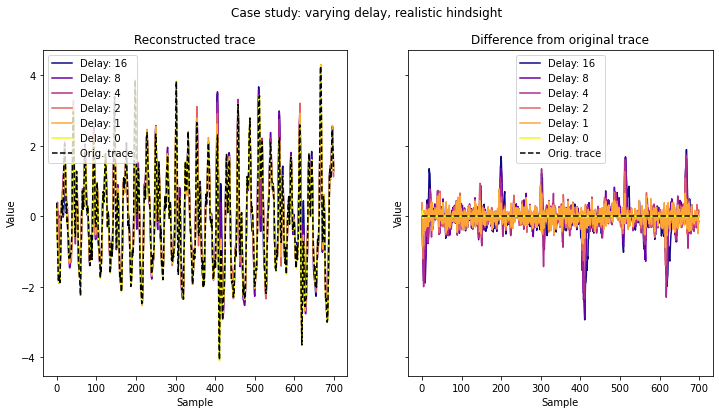

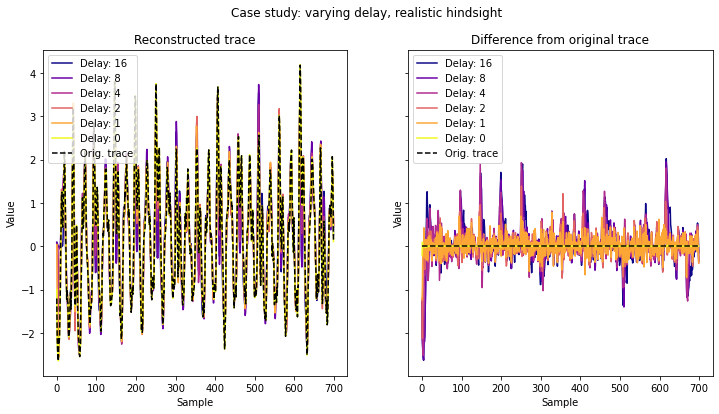

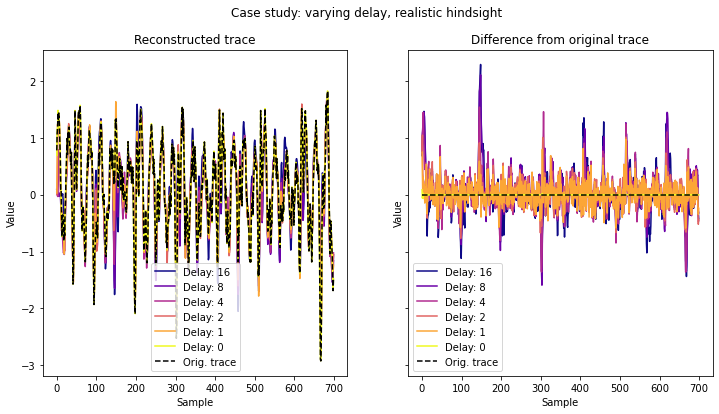

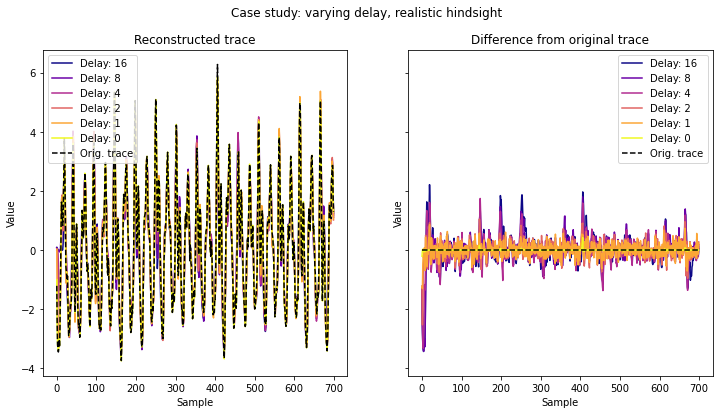

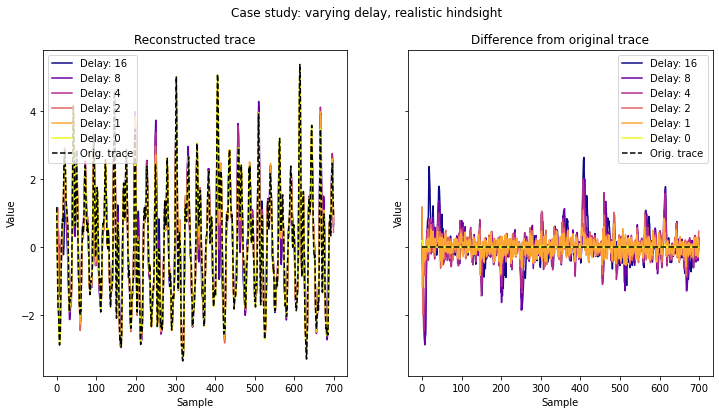

In [28]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('plasma')
colors = [cmap(i/(len(delay_values)-1)) for i in range(len(delay_values))]
n_traces = 5
traces = next(iter(test_dataloader))[0][:n_traces]
for trace in traces:
    reconstructed_traces = {}
    for realistic_hindsight in [True]:
        for delay in delay_values:
            model = torch.load(os.path.join(results_dir, 'trained_model__{}_{}.pt'.format(realistic_hindsight, delay)))
            reconstructed_trace = model(trace.unsqueeze(0).cuda()).detach().squeeze().cpu().numpy()
            reconstructed_traces[(realistic_hindsight, delay)] = reconstructed_trace

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    trace = trace.squeeze().numpy()
    for delay, color in zip(delay_values[::-1], colors):
        reconstructed_trace = reconstructed_traces[(True, delay)]
        axes[0].plot(reconstructed_trace, label='Delay: {}'.format(delay), color=color)
        axes[1].plot(trace-reconstructed_trace, label='Delay: {}'.format(delay), color=color)
    axes[0].plot(trace, color='black', linestyle='--', label='Orig. trace')
    axes[1].plot(np.zeros_like(trace), color='black', linestyle='--', label='Orig. trace')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_xlabel('Sample')
    axes[1].set_xlabel('Sample')
    axes[0].set_ylabel('Value')
    axes[1].set_ylabel('Value')
    axes[0].set_title('Reconstructed trace')
    axes[1].set_title('Difference from original trace')
    fig.suptitle('Case study: varying delay, realistic hindsight')

In [ ]:
with open(os.path.join(results_dir, 'delay_sweep.pickle'), 'rb') as F:
    test_losses = pickle.load(F)

print(test_losses)
    
plt.plot([np.min(test_losses[(False, d)]) for d in delay_values], color='blue', label='Oracle hindsight')
plt.plot([np.min(test_losses[(True, d)]) for d in delay_values], color='red', label='Realistic hindsight')
assert False

In [ ]:
model = LstmModel(delay=1, realistic_hindsight=True)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
device = 'cuda'
model = model.to(device)

print('Model:', model)
print('Loss function:', loss_fn)
print('Optimizer:', optimizer)
print('Device:', device)

In [ ]:
train_results = {}
test_results = {}

def train_epoch(update_params=True):
    if update_params:
        results = execute_epoch(train_batch, train_dataloader, model, loss_fn, optimizer, device,
                                batch_metric_fns=metrics, autoencoder=True, grad_clip_val=1.0)
    else:
        results = execute_epoch(eval_batch, train_dataloader, model, loss_fn, device,
                                batch_metric_fns=metrics, autoencoder=True)
    for key in results.keys():
        if not(key in train_results):
            train_results[key] = []
        train_results[key].append(results[key])

def test_epoch():
    results = execute_epoch(eval_batch, test_dataloader, model, loss_fn, device,
                            batch_metric_fns=metrics, autoencoder=True)
    for key in results.keys():
        if not(key in test_results):
            test_results[key] = []
        test_results[key].append(results[key])

if retrain:
    train_epoch(update_params=False)
    test_epoch()
    for epoch in tqdm(range(num_epochs)):
        train_epoch()
        test_epoch()

In [ ]:
if retrain:
    os.makedirs(results_dir, exist_ok=True)
    with open(os.path.join(results_dir, 'train_results.pickle'), 'wb') as F:
        pickle.dump(train_results, F)
    with open(os.path.join(results_dir, 'test_results.pickle'), 'wb') as F:
        pickle.dump(test_results, F)
    torch.save(model, os.path.join(results_dir, 'trained_model.pt'))

In [ ]:
with open(os.path.join(results_dir, 'train_results.pickle'), 'rb') as F:
    train_results = pickle.load(F)
with open(os.path.join(results_dir, 'test_results.pickle'), 'rb') as F:
    test_results = pickle.load(F)
model = torch.load(os.path.join(results_dir, 'trained_model.pt'))

In [ ]:
for k in train_results.keys():
    train_results[k] = [np.mean(x) for x in train_results[k]]
for k in test_results.keys():
    test_results[k] = [np.mean(x) for x in test_results[k]]
plt.plot(train_results['loss'])
plt.plot(test_results['loss'])
plt.yscale('log')

In [ ]:
from display_results import plot_autoencoder_traces
traces = next(iter(test_dataloader))[0][:4]
plot_autoencoder_traces(traces, model, device)